# Berkeley NLP Capstone

In [42]:
#Steven Johannemann, Zoe Ouyang, Chloe Zhang
#Import all needed packages
import os
import pandas as pd
import numpy as np
import string
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from gensim.models import Word2Vec, KeyedVectors
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from imblearn.over_sampling import SMOTE
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

## Import Dataset and Word2vec file

In [2]:
#Load in the data
df_ori = pd.read_csv('yelp.csv')

In [3]:
#Basic View of Data
df_ori.head()

,business_id,date,review_id,stars,text,type,user_id,cool,useful,funny
0,9yKzy9PApeiPPOUJEtnvkg,2011-01-26,fWKvX83p0-ka4JS3dc6E5A,5,My wife took me here on my birthday for breakf...,review,rLtl8ZkDX5vH5nAx9C3q5Q,2,5,0
1,ZRJwVLyzEJq1VAihDhYiow,2011-07-27,IjZ33sJrzXqU-0X6U8NwyA,5,I have no idea why some people give bad review...,review,0a2KyEL0d3Yb1V6aivbIuQ,0,0,0
2,6oRAC4uyJCsJl1X0WZpVSA,2012-06-14,IESLBzqUCLdSzSqm0eCSxQ,4,love the gyro plate. Rice is so good and I als...,review,0hT2KtfLiobPvh6cDC8JQg,0,1,0
3,_1QQZuf4zZOyFCvXc0o6Vg,2010-05-27,G-WvGaISbqqaMHlNnByodA,5,"Rosie, Dakota, and I LOVE Chaparral Dog Park!!...",review,uZetl9T0NcROGOyFfughhg,1,2,0
4,6ozycU1RpktNG2-1BroVtw,2012-01-05,1uJFq2r5QfJG_6ExMRCaGw,5,General Manager Scott Petello is a good egg!!!...,review,vYmM4KTsC8ZfQBg-j5MWkw,0,0,0


In [4]:
#Shape of Data
df_ori.shape

In [38]:
#Load the pre-trained word2vec model and the dataset
data_path= r"C:\Users\Steven Johannemann\Desktop\Capstone\Capstone Notebooks"
path_to_model = os.path.join(data_path,'GoogleNews-vectors-negative300.bin')
training_data_path = os.path.join(data_path, "sentiment_sentences.txt")

#Load W2V model. This will take some time. 
%time w2v_model = KeyedVectors.load_word2vec_format(path_to_model, binary=True)
print('done loading Word2Vec')

#Read text data, cats.
#the file path consists of tab separated sentences and cats.
texts = []
cats = []
fh = open(training_data_path)
for line in fh:
    text, sentiment = line.split("\t")
    texts.append(text)
    cats.append(sentiment)

In [39]:
# Inspect the model
word2vec_vocab = w2v_model.vocab.keys()
word2vec_vocab_lower = [item.lower() for item in word2vec_vocab]
print(len(word2vec_vocab))

3000000


## Basic Data Manipulation

In [5]:
#Create a new column for Binary Classification where 1-2 stars = negative (0) and 3-5 stars = positive (1)
df_ori["attitude"] = np.where(df_ori["stars"] >= 3, 1, 0)
#Create a new data frame that only contains the following columns
df = df_ori[['text','attitude']]

## Data Exploration and Visualization

In [6]:
#Examine the distribution of the 'attitude' column
df['attitude'].value_counts()

1    8324
0    1676
Name: attitude, dtype: int64

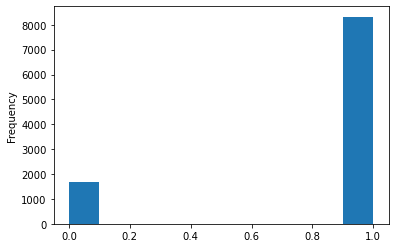

In [7]:
df['attitude'].astype(int).plot.hist();

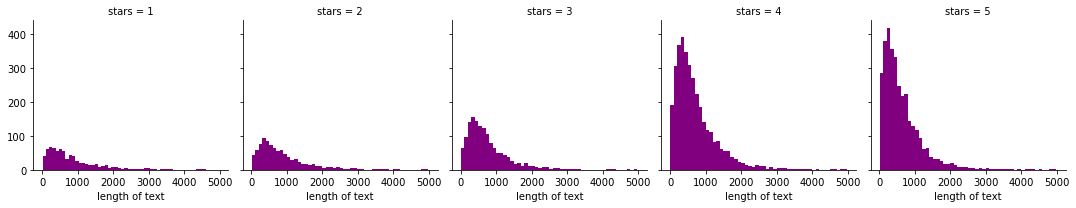

In [46]:
#Correlation between review length and rating may be insightful
df_ori['length of text'] = df_ori['text'].apply(len)
graph = sns.FacetGrid(data=df_ori,col='stars')
graph.map(plt.hist,'length of text',bins=50,color='purple')

In [8]:
# can work more on this later to create more visuals and figures

## Data Pre-processing

In [9]:
#Function for data cleaning using regular expressions
import re
def function_clean(text):
    text = re.sub(r"http\S+", "", text) #hyperlinks
    text = re.sub("@[^\s]*", "", text)
    text = re.sub("#[^\s]*", "", text)
    text = re.sub('[0-9]*[+-:]*[0-9]+', '', text) #Dates
    text = re.sub("'s", "", text) # " 's "
    return text

In [10]:
#Apply the regex function to text column
df['text'] = df['text'].apply(lambda text: function_clean(text))
X = df['text']
y = df["attitude"]

<ipython-input-10-2c6fb3533ba0>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['text'] = df['text'].apply(lambda text: function_clean(text))


In [11]:
stop_words = set(stopwords.words("english"))
porter = PorterStemmer()

def my_tokenizer(sentence):
    listofwords = sentence.strip().split()          
    listof_words = []    
    for word in listofwords:
        if not word in stop_words:
            stem_word = porter.stem(word)
            for punctuation_mark in string.punctuation:
                stem_word = stem_word.replace(punctuation_mark, '').lower()
            if len(word)>2:
                listof_words.append(stem_word)
    return(listof_words)

In [12]:
#one thing to note is that word embedding models do not require the same amount of cleaning

In [13]:
#Training/testing split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=6)

## Feature Extraction using BoW, Tf-idf and Word2Vec

In [14]:
#Use CountVectorizer for BoW and TfidfVectorizer for Tf-idf
cv = CountVectorizer(tokenizer = my_tokenizer, ngram_range=(1,3), min_df = 0.001).fit(X_train)
tfidf = TfidfVectorizer(tokenizer = my_tokenizer, ngram_range=(1,3), min_df = 0.001).fit(X_train)
X_traintfidf = tfidf.transform(X_train)
X_testtfidf = tfidf.transform(X_test)
X_traincv = cv.transform(X_train)
X_testcv = cv.transform(X_test)

C:\Users\Steven Johannemann\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:489: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


In [17]:
#Preview First 100 Feature Names
#cv.get_feature_names()[0:100]
#tfidf.get_feature_names()[0:100]

['',
 ' good',
 'a',
 'aaron',
 'abil',
 'abl',
 'abl eat',
 'abl enjoy',
 'abl find',
 'abl get',
 'abl make',
 'abl see',
 'abl tri',
 'about',
 'above',
 'absolut',
 'absolut amazing',
 'absolut best',
 'absolut delici',
 'absolut delicious',
 'absolut favorit',
 'absolut love',
 'absolut perfect',
 'abund',
 'ac',
 'accent',
 'accept',
 'acceptable',
 'accepted',
 'access',
 'accessori',
 'accid',
 'accident',
 'accommod',
 'accommodating',
 'accomod',
 'accomodating',
 'accompani',
 'accomplish',
 'accord',
 'account',
 'accustom',
 'ace',
 'achiev',
 'acknowledg',
 'acoust',
 'across',
 'across street',
 'across way',
 'act',
 'act like',
 'action',
 'activ',
 'actual',
 'actual enjoy',
 'actual get',
 'actual good',
 'actual got',
 'actual like',
 'actual order',
 'actual pretti',
 'actual pretti good',
 'actual realli',
 'actual tast',
 'actually',
 'ad',
 'adam',
 'add',
 'add flavor',
 'addict',
 'addictive',
 'addit',
 'addition',
 'additionally',
 'address',
 'adequ',
 'ade

In [18]:
#Shape of the training sets after feature extraction
print(X_traincv.shape)
print(X_traintfidf.shape)

(7000, 10359)
(7000, 10359)


## Data Augmentation using SMOTE

In [19]:
sm = SMOTE(random_state=6)
X_balcv, y_balcv = sm.fit_resample(X_traincv, y_train)
X_baltfidf, y_baltfidf = sm.fit_resample(X_traintfidf, y_train)

print(y_balcv.value_counts())
print(y_baltfidf.value_counts())

In [106]:
#Bootstrap for Confidence intervals for B = 1000, n = len(predrmfr)
#default 95% confidence, plot accuracy distribution
#test and osr_pred are 1d arrays
def confidence_bootstrap(test, ospred, conf = 0.95, b = 1000, acc = True):
    sim_acc = []
    sim_diff = []
    n = len(ospred)
    ossample = accuracy_score(test,ospred)
    
    df_data = {'real':test,'pred':ospred}
    sample_data = pd.DataFrame(df_data, columns =['real','pred'])
    
    #simulation
    for i in range(n):
        bsample = sample_data.sample(n=len(ospred),replace=True)
        sim_acc.append(accuracy_score(bsample['real'],bsample['pred']))
        sim_diff.append(accuracy_score(bsample['real'],bsample['pred']) - ossample)
    
    sim_acc.sort()
    sim_diff.sort()
   
    #onfidence Interval
    lower = int(np.floor(n*(1-conf)/2))
    upper = int(np.floor(n*(1+conf)/2))
    
    #Plots
    if acc == False:
        sns.distplot(sim_diff)
        plt.xlabel("Difference")
        plt.title("Distribution of Difference of OSR2")
    else:
        sns.distplot(sim_acc)
        plt.xlabel("Accuracy")
        plt.title("Distribution of Accuracy")
    print("Confidence Interval:", sim_acc[lower],sim_acc[upper])
    print("Lower and Upper Quantiles:",sim_diff[lower],sim_diff[upper])

## Supervised Machine Learning Models

#### Naive Bayes Models

In [107]:
#MN Naive Bayes Import
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import f1_score
mnb = MultinomialNB()

In [108]:
#MN Naive Bayes using Bag of Words
mnb.fit(X_balcv,y_balcv)
predmnb = mnb.predict(X_testcv)
print("Confusion Matrix for Multinomial Naive Bayes:")
print(confusion_matrix(y_test,predmnb))
print("Score:",round(accuracy_score(y_test,predmnb)*100,2))
print("Classification Report:",classification_report(y_test,predmnb))
print(f'f1 score: {f1_score(y_test,predmnb)}')

Confusion Matrix for Multinomial Naive Bayes:
[[ 368  117]
 [ 233 2282]]
Score: 88.33
Classification Report:               precision    recall  f1-score   support

           0       0.61      0.76      0.68       485
           1       0.95      0.91      0.93      2515

    accuracy                           0.88      3000
   macro avg       0.78      0.83      0.80      3000
weighted avg       0.90      0.88      0.89      3000

f1 score: 0.9287749287749286


Confidence Interval: 0.8716666666666667 0.8946666666666667
Lower and Upper Quantiles: -0.011666666666666603 0.011333333333333417


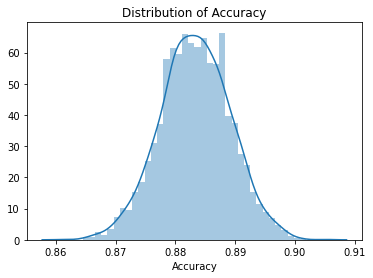

In [110]:
confidence_bootstrap(y_test.values.tolist(),predmnb)

In [33]:
#MN Naive Bayes using Tf-idf
mnb.fit(X_baltfidf,y_baltfidf)
predmnb = mnb.predict(X_testtfidf)
print("Confusion Matrix for Multinomial Naive Bayes:")
print(confusion_matrix(y_test,predmnb))
print("Score:",round(accuracy_score(y_test,predmnb)*100,2))
print("Classification Report:",classification_report(y_test,predmnb))
print(f'f1 score: {f1_score(y_test,predmnb)}')

In [ ]:
#MN Naive Bayes using Word2vec

#### Lasso Regression

In [103]:
#Logistic Regression Import
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(penalty = 'l1', solver='saga',random_state=6, C =1.0)

In [104]:
#Lasso Regression using Bag of Words
logreg.fit(X_balcv,y_balcv)
predlog = logreg.predict(X_testcv)
print("Confusion Matrix for Logistic Regression:")
print(confusion_matrix(y_test,predlog))
print("Score:",round(accuracy_score(y_test,predlog)*100,2))
print("Classification Report:",classification_report(y_test,predlog))

Confusion Matrix for Logistic Regression:
[[ 320  165]
 [ 301 2214]]
Score: 84.47
Classification Report:               precision    recall  f1-score   support

           0       0.52      0.66      0.58       485
           1       0.93      0.88      0.90      2515

    accuracy                           0.84      3000
   macro avg       0.72      0.77      0.74      3000
weighted avg       0.86      0.84      0.85      3000



C:\Users\Steven Johannemann\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


In [105]:
#Lasso Regression using Tf-idf
logreg.fit(X_baltfidf,y_baltfidf)
predlog = logreg.predict(X_testtfidf)
print("Confusion Matrix for Logistic Regression:")
print(confusion_matrix(y_test,predlog))
print("Score:",round(accuracy_score(y_test,predlog)*100,2))
print("Classification Report:",classification_report(y_test,predlog))

Confusion Matrix for Logistic Regression:
[[ 384  101]
 [ 355 2160]]
Score: 84.8
Classification Report:               precision    recall  f1-score   support

           0       0.52      0.79      0.63       485
           1       0.96      0.86      0.90      2515

    accuracy                           0.85      3000
   macro avg       0.74      0.83      0.77      3000
weighted avg       0.88      0.85      0.86      3000



C:\Users\Steven Johannemann\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


In [ ]:
#Lasso Regression using Word2vec

#### XGBoost

In [95]:
#XGBoost using Bag of Words

In [96]:
#XGBoost using Tf-idf

In [ ]:
#XGBoost using Word2vec

## Unsupervised Machine Learning Models